In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [70]:
df = pd.read_csv('../dataset/Demand Spike Detection Wallmart/Walmart.csv')
df['date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,date
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106,2010-02-05
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106,2010-02-12
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106,2010-02-19
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106,2010-02-26
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106,2010-03-05


In [71]:
# lag features
df['Lag_1'] = df.groupby('Store')['Weekly_Sales'].shift(1)
df['Lag_4'] = df.groupby('Store')['Weekly_Sales'].shift(4)

# rolling statistics
df['Rolling_Mean_4'] = df.groupby('Store')['Weekly_Sales'].transform(
    lambda x: x.rolling(4, min_periods=1).mean()
)

df['Rolling_Std_4'] = df.groupby('Store')['Weekly_Sales'].transform(
    lambda x: x.rolling(4, min_periods=1).std()
)

# drop rows with NaNs
df_model = df.dropna().copy()


In [72]:
features = [
    'Weekly_Sales',
    'Lag_1',
    'Lag_4',
    'Rolling_Mean_4',
    'Rolling_Std_4',
    'Holiday_Flag',
    'Temperature',
    'Fuel_Price',
    'CPI',
    'Unemployment'
]

X = df_model[features]


In [73]:
iso = IsolationForest(
    n_estimators=200,
    contamination=0.05,   # 5% anomalies
    random_state=42
)

df_model['target'] = (iso.fit_predict(X) == -1).astype(int)


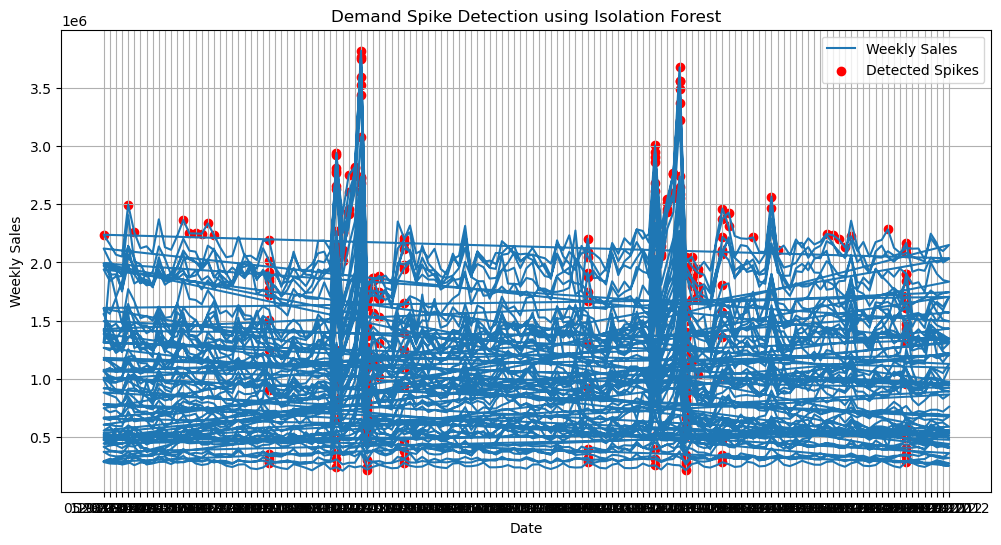

In [74]:
plt.figure(figsize=(12,6))

plt.plot(df_model['Date'], df_model['Weekly_Sales'], label='Weekly Sales')
plt.scatter(
    df_model[df_model['target']==1]['Date'],
    df_model[df_model['target']==1]['Weekly_Sales'],
    color='red',
    label='Detected Spikes'
)

plt.title("Demand Spike Detection using Isolation Forest")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.grid(True)
plt.show()


In [75]:
tscv = TimeSeriesSplit(n_splits=5)
iso
cv_scores = []

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    
    iso_cv = IsolationForest(
        n_estimators=200,
        contamination=0.05,
        random_state=42
    )
    
    iso_cv.fit(X_train)
    preds = (iso_cv.predict(X_test) == -1).astype(int)
    
    # anomaly consistency score
    cv_scores.append(preds.mean())

print("Average anomaly rate across folds:", np.mean(cv_scores))


Average anomaly rate across folds: 0.07332053742802302


In [76]:
# statistical baseline (25% above rolling mean)
df_model['stat_label'] = (
    df_model['Weekly_Sales'] > 1.25 * df_model['Rolling_Mean_4']
).astype(int)

print("Accuracy:", accuracy_score(df_model['stat_label'], df_model['target']))
print("\nClassification Report:\n")
print(classification_report(df_model['stat_label'], df_model['target']))


Accuracy: 0.948361310951239

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      6135
           1       0.18      0.46      0.25       120

    accuracy                           0.95      6255
   macro avg       0.58      0.71      0.61      6255
weighted avg       0.97      0.95      0.96      6255



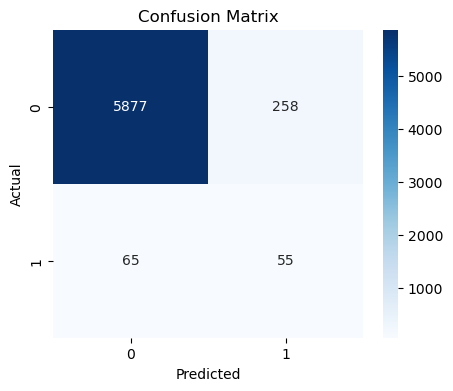

In [77]:
cm = confusion_matrix(df_model['stat_label'], df_model['target'])

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [81]:
joblib.dump(iso, "model_checkpoints/demand_spike_isolation_forest.pkl")

['model_checkpoints/demand_spike_isolation_forest.pkl']